In [1]:
%%bash
pip3 install gymnasium[classic_control] matplotlib

In [2]:
import numpy as np
import gym_envs.envs.traffic_light_support_functions as tlsf
import traci

cycleTime = 60
minGreentime = 5
numberOfPhases = 6
intergreenMatrix = np.zeros((numberOfPhases, numberOfPhases))
intergreenMatrix = [
    [0, 0, 0, 7, 6, 6],
    [0, 0, 0, 5, 0, 0],
    [8, 0, 0, 0, 5, 0],
    [6, 6, 0, 0, 8, 0],
    [8, 0, 6, 5, 0, 0],
    [6, 0, 0, 0, 0, 0],
]

phasePlan = np.full((numberOfPhases,cycleTime), 0)

initialPhaseplan = np.full((numberOfPhases, cycleTime),'r')

starting_phases = [1, 1, 2, 2, 1, 2]
phase_lengths = [
    [19, 2, 14, 3, 22],
    [41, 2, 13, 4],
    [2, 34, 3, 21],
    [2, 13, 3, 42],
    [40, 2, 14, 3, 1],
    [2, 13, 3, 42]
]

initialPhaseplan = tlsf.generate_phase_plan(starting_phases, phase_lengths)
initialPhaseplan = tlsf.change_phase_plan((5,5),60)

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('TrafficEnv-V0', render_mode ='console', starting_phases = starting_phases, phase_lengths = phase_lengths, simulation_time= 3600*5)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

 Retrying in 1 seconds


In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensordict import TensorDict

class DQN(nn.Module):
    def __init__(self, observation_space, n_actions):
        super(DQN, self).__init__()
        
        # Occupancy és vehicle_count feldolgozása
        self.fc_occupancy = nn.Linear(observation_space['occupancy'].shape[0], 64)
        self.fc_vehicle_count = nn.Linear(observation_space['vehicle_count'].shape[0], 64)
        
        # Last five phaseplan feldolgozása
        # phaseplan_shape = observation_space['last_five_phaseplan'].shape
        # self.conv_phaseplan = nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        # self.fc_phaseplan = nn.Linear(32 * phaseplan_shape[0] * phaseplan_shape[1] * phaseplan_shape[2], 128)
        
        # Közös feldolgozó rétegek
        #self.fc1 = nn.Linear(64 + 64 + 128, 256)
        self.fc1 = nn.Linear(64 + 64, 256)  # Removed + 128
        self.fc2 = nn.Linear(256, n_actions)

    def forward(self, x: TensorDict):
        occupancy = F.relu(self.fc_occupancy(x['occupancy']))
        vehicle_count = F.relu(self.fc_vehicle_count(x['vehicle_count']))
        
        # phaseplan = x['last_five_phaseplan'].unsqueeze(1)  # Add channel dimension
        # phaseplan = F.relu(self.conv_phaseplan(phaseplan))
        # phaseplan = phaseplan.view(phaseplan.size(0), -1)
        # phaseplan = F.relu(self.fc_phaseplan(phaseplan))
        
        #combined = torch.cat((occupancy, vehicle_count, phaseplan), dim=1)
        combined = torch.cat((occupancy, vehicle_count), dim=1)  # Removed , phaseplan
        x = F.relu(self.fc1(combined))
        return self.fc2(x)

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()


policy_net = DQN(env.observation_space, n_actions).to(device)
target_net = DQN(env.observation_space, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
eps_threshold = None


def select_action(state: TensorDict):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_rewards = []
episode_epsilons = []


def plot_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    
    display.clear_output()
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.display(plt.gcf())
    
    plt.figure(2)
    plt.plot(episode_epsilons)
    plt.title('Epsilon values over episodes')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.show()
    #if is_ipython:
    #    if not show_result:
    #        display.display(plt.gcf())
    #        display.clear_output(wait=True)
    #    else:
    #        display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.cat([s for s in batch.next_state
    #                                            if s is not None])
    non_final_next_states = TensorDict({
        'occupancy': torch.cat([s['occupancy'] for s in batch.next_state if s is not None]),
        'vehicle_count': torch.cat([s['vehicle_count'] for s in batch.next_state if s is not None]),
        #'last_five_phaseplan': torch.cat([s['last_five_phaseplan'] for s in batch.next_state if s is not None])
    })
    
    #state_batch = torch.cat(batch.state)
    state_batch = TensorDict({
        'occupancy': torch.cat([s['occupancy'] for s in batch.state]),
        'vehicle_count': torch.cat([s['vehicle_count'] for s in batch.state]),
        #'last_five_phaseplan': torch.cat([s['last_five_phaseplan'] for s in batch.state])
    })

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

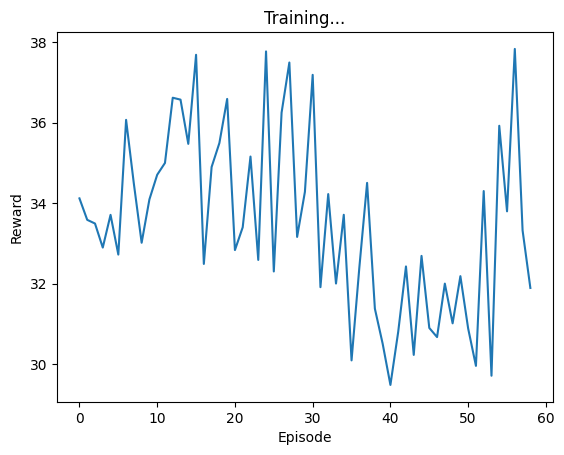

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

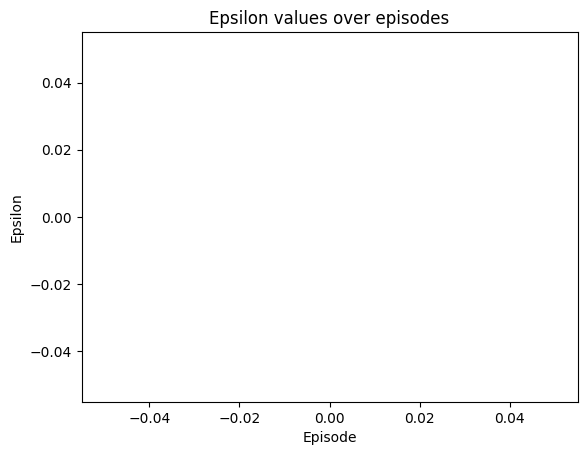

Episode number:  59
Step #18300.00 (1ms ~= 1000.00*RT, ~129000.00UPS, TraCI: 103ms, vehicles TOT 10405 ACT 129
Interrupt signal received, trying to exit gracefully.OT 3112 ACT 90 BUF 1268)             


KeyboardInterrupt: 

In [8]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state  = TensorDict({
        'occupancy' : torch.tensor(state['occupancy'], dtype=torch.float32, device=device).unsqueeze(0),
        'vehicle_count' : torch.tensor(state['vehicle_count'], dtype=torch.float32, device=device).unsqueeze(0),
        #'last_five_phaseplan' : torch.tensor(state['last_five_phaseplan'], dtype=torch.float32, device=device).unsqueeze(0)
    })
    print("Episode number: ", i_episode)
    reward_per_episode = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(np.array([action.item()]))
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        reward_per_episode += reward.item()

        if terminated:
            next_state = None
        else:
            next_state = TensorDict({
                'occupancy' : torch.tensor(observation['occupancy'], dtype=torch.float32, device=device).unsqueeze(0),
                'vehicle_count' : torch.tensor(observation['vehicle_count'], dtype=torch.float32, device=device).unsqueeze(0),
                #'last_five_phaseplan' : torch.tensor(observation['last_five_phaseplan'], dtype=torch.float32, device=device).unsqueeze(0)
            })

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_epsilons.append(eps_threshold)
            episode_rewards.append(reward_per_episode)
            print("Rewards:", )
            plot_rewards()
            break



In [ ]:
print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

